# Long term stability of Trappist-1
The Trappist-1 system (see https://en.wikipedia.org/wiki/TRAPPIST-1) long-term stability has been debated and studied in a series of high-visibility works. 

Here we show how to use heyoka to setup a parallel simulation of the long-term stability of the system starting from several initial conditions. 

Thread parallelism is possible as the heyoka Taylor integrator releases the python GIL.

In [102]:
#core
import heyoka as hey
import numpy as np
import pykep as pk

#plots
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

#misc
from copy import deepcopy
from multiprocessing.pool import ThreadPool
from scipy.optimize import newton

## Here we define the data of the Trappist-1 system
In the code below, we define a number of physical properties of the Trappist-1 system. We will be using SI units throughout.

In [99]:
# Cavendish constant (kg m^3/s^2)
G = 6.67430E-11
# Sun_mass (kg)
SM = 1.989E30
# Earth mass (kg)
EM = 5.972E24
# Mass of the star
MS = 0.0898 * SM
MSs = 0.0023
# Start of the simulation
t_start = 7257.93115525 * pk.DAY2SEC
# This data comes from the paper (https://arxiv.org/pdf/2010.01074.pdf) tab.II
mu =  np.array([1.3771,1.3105,0.3885,0.6932,1.0411,1.3238,0.3261])
mus = np.array([0.0593,0.0453,0.0074,0.0128,0.0155,0.0171,0.0186])
P = np.array([1.510826, 2.421937, 4.049219, 6.101013, 9.207540,12.352446,18.772866]) * pk.DAY2SEC
Ps = np.array([0.000006,0.000018,0.000026,0.000035,0.000032,0.000054,0.000214]) * pk.DAY2SEC
t0 = np.array([7257.55044,7258.58728,7257.06768,7257.82771,7257.07426,7257.71462,7249.60676]) * pk.DAY2SEC
t0s = np.array([0.00015,0.00027,0.00067,0.00041,0.00085,0.00103,0.00272]) * pk.DAY2SEC
ecosw = np.array([-0.00215, 0.00055,-0.00496, 0.00433,-0.00840, 0.00380,-0.00365])
ecosws =  np.array([0.00332,0.00232,0.00186,0.00149,0.00130,0.00112,0.00077])
esinw = np.array([ 0.00217, 0.00001, 0.00267,-0.00461,-0.00051, 0.00128,-0.00002])
esinws = np.array([0.00244,0.00171,0.00112,0.00087,0.00087,0.00070,0.00044])
# We put everything in a dictionary for cenvenience
data = dict()
data["MS"] = MS
data["MSs"] = MSs
data["mu"] = mu
data["mus"] = mus
data["P"] = P
data["Ps"] = Ps
data["t0"] = t0
data["t0s"] = t0s
data["t_start"] = t_start
data["ecosw"] = ecosw
data["ecosws"] = ecosws
data["esinw"] = esinw
data["esinws"] = esinws
data["G"] = G
data["m_earth"] = EM
data["m_sun"] = SM

## Some auxiliary functions
Here we define a number of helper functions that will visualize as well as generate plausible Trappist-1 configurations.

In [274]:
# Plots the trappist system
def plot_trappist(state, mu, axes = None):
    letter = ["s", "a", "b", "c", "d", "e", "f", "g", "h"]
    colors = ["y", "C0", "C1", "C2", "C3", "C4", "C5", "C6", "C7"]
    if axes is None:
        fig = plt.figure()
        axes = fig.add_subplot(111, projection='3d', aspect='auto')
    for i in range(1,8):
        el = pk.ic2par(state[i*6:3+i*6], state[3+i*6:6+i*6], mu)
        pla = pk.planet.keplerian(pk.epoch(0), el, mu, 1., 1., 1. , "Trappist-1"+letter[i])
        pk.orbit_plots.plot_planet(pla, axes=axes, color=colors[i])
    plt.axis('off')
    plt.tight_layout()
    axes.view_init(elev=0., azim=90.)
    axes.scatter(0,0,0,s=40,c='y')
    return axes

# Generates N plausible trappist systems
def trappist_generator(N, trappist_data):
    G, m_earth, m_sun = data["G"], data["m_earth"], data["m_sun"]
    retval_ic = []
    retval_m = []
    
    for i in range(N):
        # First we generate the stellar mass
        m_star = data["MS"] + data["MSs"] * (np.random.random()*2-1)

        # Then we generate masses for the planets
        m_pl = data["mu"] + data["mus"] * (np.random.random()*2-1)
        m_pl = m_pl * m_earth * m_star / (m_sun * 0.09)

        # And compute the Jacobi masses "The Jacobi mass of planet i 
        # includes also the masses of all objects with a smaller 
        # semi-major axis."
        m_jacobi = np.cumsum(m_pl)

        # Then we generate the periods P
        P_pl = data["P"] + data["Ps"] * (np.random.random()*2-1)

        # And compute the semi-major axes from them
        a_pl = (P_pl / 2. / np.pi)**2 * G * (m_jacobi + m_star)
        a_pl = a_pl**(1./3.)

        # Then we generate the ecos, esin 
        ecosw = data["ecosw"] + data["ecosws"] * (np.random.random()*2-1) 
        esinw = data["esinw"] + data["esinws"] * (np.random.random()*2-1) 

        # And compute eccentricites and argument of peristars
        e_pl = np.sqrt(ecosw**2 + esinw**2)
        w_pl = np.arctan2(esinw, ecosw)

        # And compute the mean anomalies at transit
        ni_pl_t = np.pi/2 - w_pl
        E_pl_t = np.tan(ni_pl_t/2) * np.sqrt((1 - e_pl)/(1 + e_pl))
        E_pl_t = np.arctan(E_pl_t)
        E_pl_t = E_pl_t * 2
        M_pl_t = E_pl_t - E_pl_t * np.sin(E_pl_t)

        # And we set inclinations and RAAN accordingly
        RAAN_pl = np.zeros(7)
        incl_pl = np.ones(7) * np.pi/2

        # Then we generate the t0
        t0_pl = data["t0"] + data["t0s"] * (np.random.random()*2-1) 

        # And we compute the mean anomalies
        M_pl = M_pl_t - ((t0_pl - data["t_start"]) * np.pi * 2) / P_pl


        # With all of the orbital parameters defined we can instantiate the ICs
        ic_tr = [0,0,0,0,0,0]
        for j in range(7):
            # Newton method to find E from M
            E = newton(lambda E, e, M: E-e*np.sin(E) - M, M_pl[j] + e_pl[j]*np.cos(M_pl[j]), args = (e_pl[j], M_pl[j]))
            r,v = pk.par2ic([a_pl[j], e_pl[j], incl_pl[j], RAAN_pl[j], w_pl[j], E], G * m_star)
            ic_tr = ic_tr + list(r) + list(v)
        ic_tr = np.array(ic_tr)

        # Assemble the return masses into one 
        m_tr = [m_star] + list(m_pl)
        m_tr = np.array(m_tr)

        # And place the star so that the COM is at the origin
        for j in range(6):
            ic_tr[0+j] = - sum(ic_tr[6+j::6]*(m_tr[1:] / m_tr[0])) 
            
        retval_ic.append(ic_tr)
        retval_m.append(m_tr)
    return retval_m, retval_ic

<IPython.core.display.Javascript object>


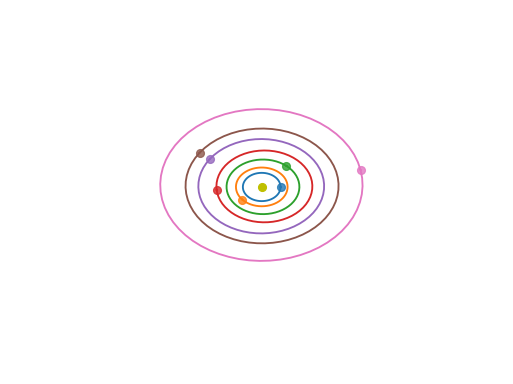

<Axes3DSubplot:>

In [282]:
m_tr, ic_tr = trappist_generator(1, data)
plot_trappist(ic_tr[0], data["G"] * data["MS"])

## Multiprocessing script
This is the main part of the script. The scripts output is recorded in files as to make sure, in long simulations, to not lose intermediate data. 

In this particular notebook the simulation is only 500 years long and takes a few seconds. Changing the setup (and waiting longer) it is possible to simulate Myrs.

In [284]:
# Number of parallel process
nproc = 4
# Number of instances of the problem (i.e. ic to try)
ninst = 4
# Final integration time in Myr
final_time_Myr = 500 / 1e6
# Log frequency in years
log_frequency = 100
# Total number of log lines
N = int(final_time_Myr*1e6/log_frequency)
print("Number of final files generated: {:d}".format(N+1))
# We generate the various trappist systems
m, ic = trappist_generator(ninst, data)


Number of final files generated: 6


In [285]:
# This will simulate, monitor and log the i-th initial condition
def runner(i):
    # Generates the EOMs
    ode_sys = hey.make_nbody_sys(8, Gconst = G, masses = m[i])
    # Generates the Taylor integrator
    ta = hey.taylor_adaptive(ode_sys, ic[i], high_accuracy=True, tol=1e-18, compact_mode=True)
    dt = log_frequency * 365.25 * pk.DAY2SEC
    
    def data_saver(j, state):           
            np.save('trappist1_{}_{}.npy'.format(i,j), state)
            
    try:
        data_saver(0, ta.state)
        for j in range(1, N+1):
            oc, _, _, nsteps = ta.propagate_for(dt)
            data_saver(j, ta.state)
            if oc != hey.taylor_outcome.time_limit:
                break
    except BaseException as e:
        print("Exception caught in thread. The full error message:\n{}".format(str(e)), flush=True)
        

In [286]:
np.save('trappist1_masses.npy', m)
with ThreadPool(processes=nproc) as pool:
    pool.map(runner, range(ninst))

## Processing the simulation output


In [287]:
# This load the i-th simulation up to N * log_frequency years (if the files exist)
def load_sim(i, N):
    ret = []
    for j in range(N):
        try:
            tmp = np.load('trappist1_{}_{}.npy'.format(i,j))
            ret.append(tmp)
        except FileNotFoundError:
            pass
    return np.array(ret)

<IPython.core.display.Javascript object>


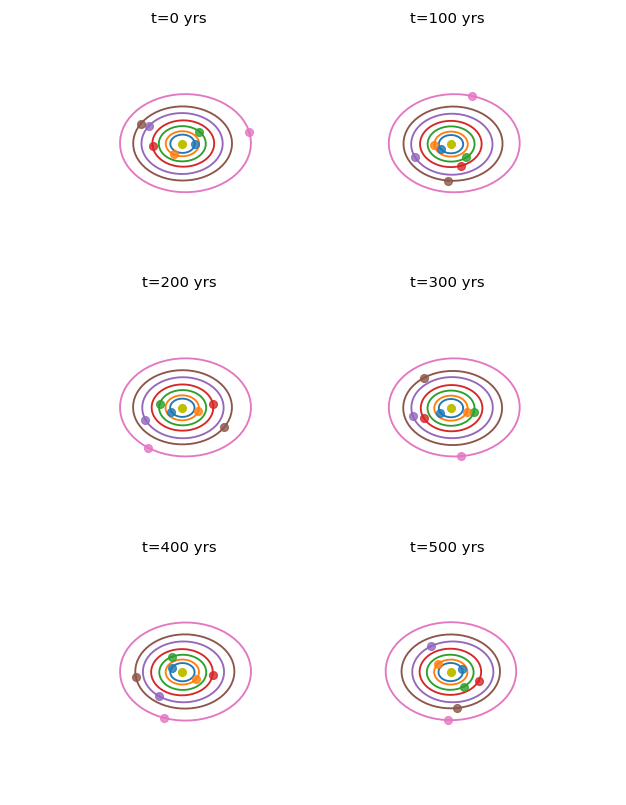

In [293]:
# Plots the system at 6 different epochs (bins of log_frequency years)
epochs = [0,1,2,3,4,5]
sim_id = 3
states = load_sim(sim_id,N+1)
mu = G*m[sim_id][0]

fig = plt.figure(figsize=(7,9))
for i in range(6):
    n = 320 + i + 1
    ax = fig.add_subplot(n, projection='3d', aspect='auto')
    ax = plot_trappist(states[epochs[i]], mu, axes = ax)
    ax.title.set_text('t='+str(log_frequency * epochs[i])+" yrs")